#Part 2

## Part 2.1

### Data Preparation + Cleaning

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_selection, linear_model, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

In [4]:
# read csv (google collab)
data_url = "/content/gdrive/MyDrive/UNI/Big Data Problem/Manhattan12.csv"
df = pd.read_csv(data_url, header = 4)
df = df.iloc[18:] #delete first 18 rows due to lack of data
df.shape

(27377, 21)

In [5]:
df.head()

BOROUGH               NEIGHBORHOOD  \
18        1  ALPHABET CITY               
19        1  ALPHABET CITY               
20        1  ALPHABET CITY               
21        1  ALPHABET CITY               
22        1  ALPHABET CITY               

                         BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
18  03  THREE FAMILY HOMES                                          1    377   
19  04  TAX CLASS 1 CONDOS                                         1C    399   
20  07  RENTALS - WALKUP APARTMENTS                                2B    374   
21  07  RENTALS - WALKUP APARTMENTS                                 2    375   
22  07  RENTALS - WALKUP APARTMENTS                                 2    376   

     LOT EASE-MENT BUILDING CLASS AT PRESENT  \
18    66                                  C0   
19  1102                                  R6   
20     1                                  C7   
21    62                                  C4   
22    30                                  C4   

                                        ADDRESS APART\nMENT\nNUMBER  ...  \
18   243 EAST 7TH   STREET                                           ...   
19   238 EAST 4TH   STREET                             -             ...   
20   303 EAST 4TH STREET                                             ...   
21   715 EAST 5TH   STREET                                           ...   
22   274 EAST SEVENTH STREET                                         ...   

    RESIDENTIAL UNITS COMMERCIAL UNITS  TOTAL UNITS LAND SQUARE FEET  \
18                  3                0            3            2,381   
19                  1                0            1                0   
20                  8                2           10            1,501   
21                 20                0           20            2,426   
22                 13                0           13            2,726   

   GROSS SQUARE FEET YEAR BUILT  TAX CLASS AT TIME OF SALE  \
18             3,084       1899                          1   
19                 0       1955                          1   
20             6,929       1900                          2   
21             9,345       1900                          2   
22            13,002       1910                          2   

    BUILDING CLASS AT TIME OF SALE SALE\nPRICE   SALE DATE  
18                             C0   $3,150,000  06/03/2013  
19                             R6   $3,450,000  27/03/2013  
20                             C7           $0  05/02/2013  
21                             C4   $3,650,000  06/09/2012  
22                             C4     $895,250  25/10/2012  

[5 rows x 21 columns]

In [6]:
df = df.rename(columns={"SALE\nPRICE":"SALE PRICE", "APART\nMENT\nNUMBER":"APARTMENT NUMBER"}) #rename columns

In [7]:
df = df.drop(columns=['BOROUGH', 'EASE-MENT', 'APARTMENT NUMBER'])

In [8]:
def price_to_int(column):
    df[column] = df[column].str.replace(',','', regex=True).str.replace('$','', regex=True).astype('int')
  
price_to_int('SALE PRICE')
price_to_int('LAND SQUARE FEET')
price_to_int('GROSS SQUARE FEET')
price_to_int('TOTAL UNITS')
price_to_int('RESIDENTIAL UNITS')

In [9]:
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].str.strip()
df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].str.strip()

In [10]:
# list all numerical variables 
df_nums = df.select_dtypes(include=[np.number])
list(df_nums)

['BLOCK',
 'LOT',
 'ZIP CODE',
 'RESIDENTIAL UNITS',
 'COMMERCIAL UNITS',
 'TOTAL UNITS',
 'LAND SQUARE FEET',
 'GROSS SQUARE FEET',
 'YEAR BUILT',
 'TAX CLASS AT TIME OF SALE',
 'SALE PRICE']

In [11]:
# list all categorical values
df_cat = df.select_dtypes(include=[object])
list(df_cat)

['NEIGHBORHOOD',
 'BUILDING CLASS CATEGORY',
 'TAX CLASS AT PRESENT',
 'BUILDING CLASS AT PRESENT',
 'ADDRESS',
 'BUILDING CLASS AT TIME OF SALE',
 'SALE DATE']

In [12]:
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], dayfirst=True) # convert sale date to datetime

In [13]:
# replace 0 with NaN
df.replace(0, np.nan, inplace=True) 
df.replace("0", np.nan, inplace=True)

pd.isnull(df).sum()

NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                  0
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT             0
ADDRESS                               0
ZIP CODE                              1
RESIDENTIAL UNITS                 16354
COMMERCIAL UNITS                  23944
TOTAL UNITS                        9687
LAND SQUARE FEET                  22888
GROSS SQUARE FEET                 23051
YEAR BUILT                         6424
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                         7593
SALE DATE                             0
dtype: int64

In [14]:
# finding out how many dupliactes there are by subtracting duplicates from 'drop duplicates' from entire dataframe
len(df)-len(df.drop_duplicates())

1593

In [15]:
df.drop_duplicates(keep='first', inplace=True)
df.dropna(subset=['ZIP CODE'], inplace=True)

df.shape

(25783, 18)

In [16]:
pd.isnull(df).sum()

NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                  0
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT             0
ADDRESS                               0
ZIP CODE                              0
RESIDENTIAL UNITS                 14996
COMMERCIAL UNITS                  23125
TOTAL UNITS                        9617
LAND SQUARE FEET                  22119
GROSS SQUARE FEET                 22268
YEAR BUILT                         5826
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                         6872
SALE DATE                             0
dtype: int64

In [17]:
#Using linear interpolation to fill in the missing gaps in all the data.
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].interpolate(method ='linear', limit_direction ='both')
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].interpolate(method ='linear', limit_direction ='both')
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].interpolate(method ='linear', limit_direction ='both')
df['YEAR BUILT'] = df['YEAR BUILT'].interpolate(method ='linear', limit_direction ='both')
df['COMMERCIAL UNITS'] = df['COMMERCIAL UNITS'].interpolate(method ='linear', limit_direction ='both')
df['RESIDENTIAL UNITS'] = df['RESIDENTIAL UNITS'].interpolate(method ='linear', limit_direction ='both')
df['SALE PRICE'] = df['SALE PRICE'].interpolate(method ='linear', limit_direction ='both')
df["BUILDING CLASS CATEGORY"] = df["BUILDING CLASS CATEGORY"].interpolate(method='pad')

pd.isnull(df).sum()

NEIGHBORHOOD                         0
BUILDING CLASS CATEGORY              0
TAX CLASS AT PRESENT                 0
BLOCK                                0
LOT                                  0
BUILDING CLASS AT PRESENT            0
ADDRESS                              0
ZIP CODE                             0
RESIDENTIAL UNITS                    0
COMMERCIAL UNITS                     0
TOTAL UNITS                       9617
LAND SQUARE FEET                     0
GROSS SQUARE FEET                    0
YEAR BUILT                           0
TAX CLASS AT TIME OF SALE            0
BUILDING CLASS AT TIME OF SALE       0
SALE PRICE                           0
SALE DATE                            0
dtype: int64

In [18]:
def convert_to_int(column): #Converts columns to the integer type
  df[column] = df[column].apply(int)

columns_to_int = ["COMMERCIAL UNITS", "RESIDENTIAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET", "YEAR BUILT", "ZIP CODE", "SALE PRICE"]

for x in columns_to_int:
  convert_to_int(x)

In [19]:
df.dtypes

NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                   object
TAX CLASS AT PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING CLASS AT PRESENT                 object
ADDRESS                                   object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                              float64
LAND SQUARE FEET                           int64
GROSS SQUARE FEET                          int64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE                  int64
BUILDING CLASS AT TIME OF SALE            object
SALE PRICE                                 int64
SALE DATE                         datetime64[ns]
dtype: object

In [20]:
df['TOTAL UNITS'] = df['RESIDENTIAL UNITS'] + df['COMMERCIAL UNITS'] #Add the residential and commercial units together
df["TOTAL UNITS"] = df["TOTAL UNITS"].apply(int)

In [21]:
df.loc[:, ~df.columns.isin(['ZIP CODE', 'BLOCK', 'LOT', 'TIME OF SALE', 'TAX CLASS AT TIME OF SALE'])].describe()

RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  \
count       25783.000000      25783.000000  25783.000000      25783.000000   
mean           39.194780          2.138502     41.333282       9348.552108   
std            83.682712          5.297819     83.882421      12158.855454   
min             1.000000          1.000000      2.000000        200.000000   
25%             1.000000          1.000000      2.000000       2595.000000   
50%             6.000000          1.000000      9.000000       5707.000000   
75%            38.000000          2.000000     40.000000      10098.500000   
max          1328.000000        604.000000   1349.000000     213650.000000   

       GROSS SQUARE FEET    YEAR BUILT    SALE PRICE  
count       2.578300e+04  25783.000000  2.578300e+04  
mean        7.054211e+04   1951.857619  4.144339e+06  
std         1.011706e+05     36.260166  2.979704e+07  
min         2.530000e+02   1000.000000  1.000000e+00  
25%         1.124500e+04   1923.000000  3.850000e+05  
50%         3.367100e+04   1952.000000  8.200000e+05  
75%         1.024245e+05   1985.000000  1.920500e+06  
max         1.970736e+06   2013.000000  1.307965e+09

In [22]:
def boxplot(column):
    sns.boxplot(x=df[column])
    plt.show()

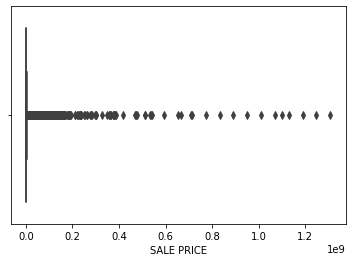

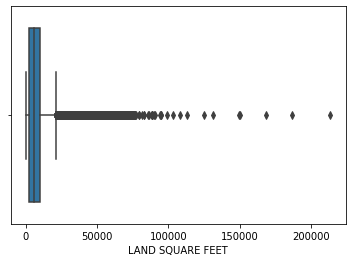

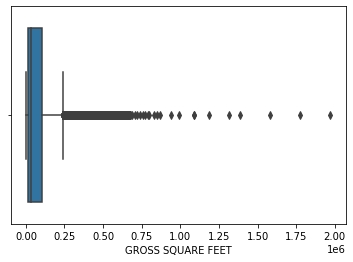

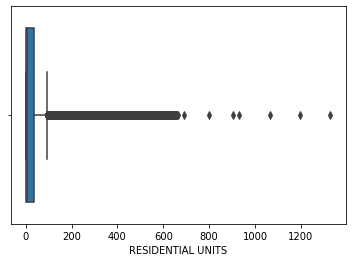

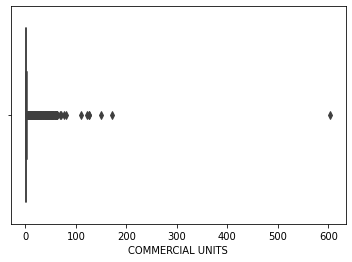

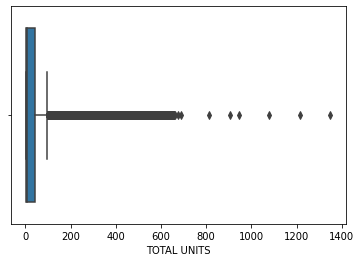

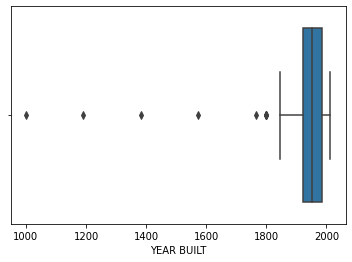

In [23]:
# identifying outliers
check_outlier_columns = ['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'YEAR BUILT']

for x in check_outlier_columns:
  boxplot(x)

In [24]:
df.shape

(25783, 18)

In [25]:
def remove_outliers(df, column, direction):
    q_low = df[column].quantile(0.025)
    q_hi  = df[column].quantile(0.975) #1.96 std
    print(column, q_low)
    if direction == "both":
      df = df[(df[column] < q_hi) & (df[column] > q_low)]
    elif direction == "higher":
      df = df[(df[column] < q_hi)]
    elif direction == "lower":
      df = df[(df[column] > q_low)]

    return df

In [26]:
df = remove_outliers(df, "YEAR BUILT", "both")
df = remove_outliers(df, "COMMERCIAL UNITS", "higher")
df = remove_outliers(df, "RESIDENTIAL UNITS", "higher")
df = remove_outliers(df, "TOTAL UNITS", "higher")
df = remove_outliers(df, "GROSS SQUARE FEET", "both")
df = remove_outliers(df, "LAND SQUARE FEET", "both")
df = remove_outliers(df, "SALE PRICE", "both")

YEAR BUILT 1900.0
COMMERCIAL UNITS 1.0
RESIDENTIAL UNITS 1.0
TOTAL UNITS 2.0
GROSS SQUARE FEET 3772.0
LAND SQUARE FEET 1573.0
SALE PRICE 200.0


In [27]:
print(df.shape)
print(df["SALE PRICE"][df["SALE PRICE"] < 200000].count())
df.drop(df[df['SALE PRICE'] <= 200000].index, inplace = True)

(18427, 18)
3640


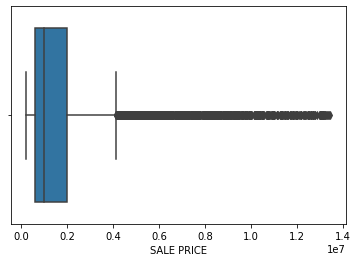

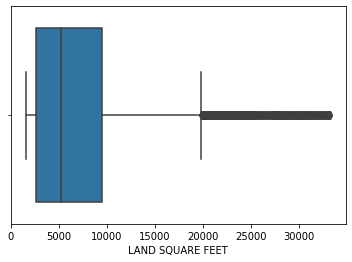

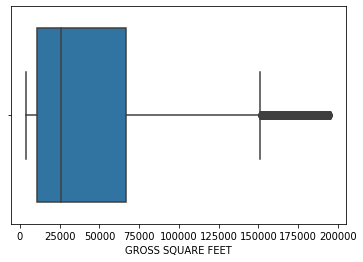

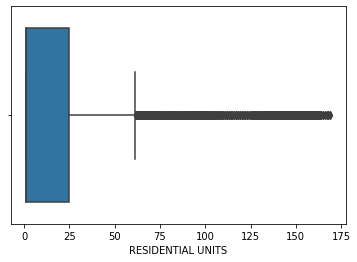

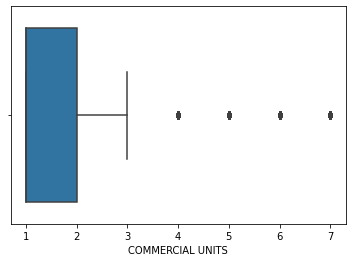

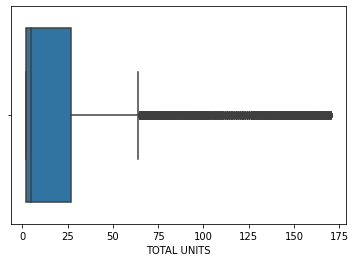

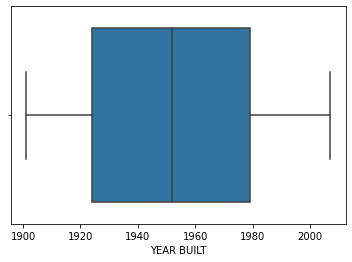

In [28]:
# identifying outliers
check_outlier_columns = ['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'YEAR BUILT']

for x in check_outlier_columns:
  boxplot(x)

In [29]:
df.drop(df.loc[df['BUILDING CLASS CATEGORY']=="25  LUXURY HOTELS"].index, inplace=True) #remove due to bad interpolation
df[df["BUILDING CLASS CATEGORY"] == "25  LUXURY HOTELS"].shape

(0, 18)

In [30]:
df.shape

(14760, 18)

In [31]:
df['LN SALE PRICE'] = np.log(df['SALE PRICE'])

In [32]:
def normalise(df):
    num_cols=df.select_dtypes(include=[np.number]).copy()
    df_norm=((num_cols-num_cols.min())/(num_cols.max()-num_cols.min()))
    return df_norm

df_norm=normalise(df)

In [33]:
df_norm.head()

BLOCK       LOT  ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  \
19  0.173292  0.120777  0.017316           0.000000          0.166667   
22  0.163019  0.003181  0.017316           0.071429          0.000000   
26  0.172398  0.003510  0.017316           0.142857          0.166667   
34  0.173738  0.006472  0.017316           0.101190          0.166667   
36  0.175525  0.000329  0.017316           0.142857          0.166667   

    TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET  YEAR BUILT  \
19     0.005952          0.011591           0.006436    0.509434   
22     0.071429          0.036384           0.048207    0.084906   
26     0.148810          0.063167           0.075423    0.226415   
34     0.107143          0.026214           0.027170    0.113208   
36     0.148810          0.045670           0.059490    0.179245   

    TAX CLASS AT TIME OF SALE  SALE PRICE  LN SALE PRICE  
19                   0.000000    0.245070       0.676383  
22                   0.333333    0.052396       0.355695  
26                   0.333333    0.979312       0.995105  
34                   0.333333    0.512802       0.844577  
36                   0.333333    0.935440       0.984379

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


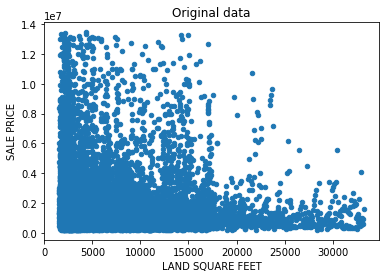

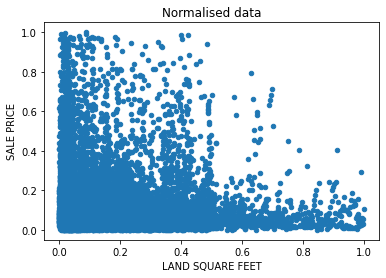

In [34]:
def scatter_plot(df, x, y, title):
    df.plot.scatter(x=x, y=y, title=title)
    plt.show()

scatter_plot(df, 'LAND SQUARE FEET', 'SALE PRICE', 'Original data')
scatter_plot(df_norm, 'LAND SQUARE FEET', 'SALE PRICE', 'Normalised data')

count    1.476000e+04
mean     1.741131e+06
std      2.017106e+06
min      2.005000e+05
25%      5.829775e+05
50%      9.770000e+05
75%      2.000000e+06
max      1.346000e+07
Name: SALE PRICE, dtype: float64

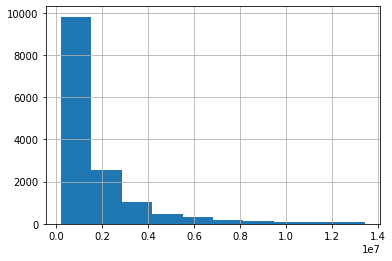

In [35]:
df['SALE PRICE'].hist()
df['SALE PRICE'].describe()

### Data Visualisation

In [ ]:
def line_plot(df, x):
    sns.lineplot(data=df, x=x, y='SALE PRICE')
    plt.show()

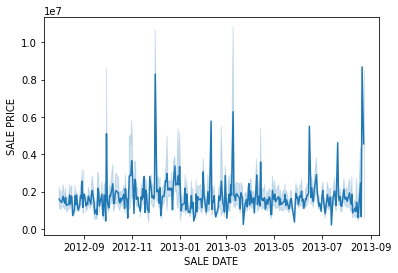

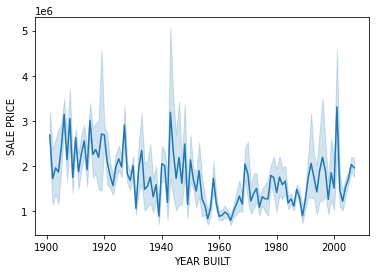

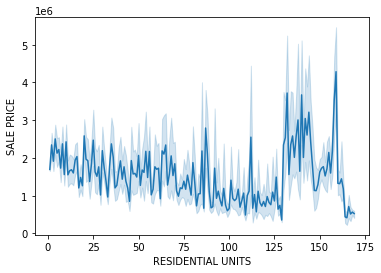

In [ ]:
line_plot(df, 'SALE DATE')
line_plot(df, 'YEAR BUILT')
line_plot(df, 'RESIDENTIAL UNITS')

In [ ]:
def bar_plot(df, x):
    plt.figure(figsize=(40,10))
    sns.barplot(data=df, x=x, y='SALE PRICE')
    plt.show()

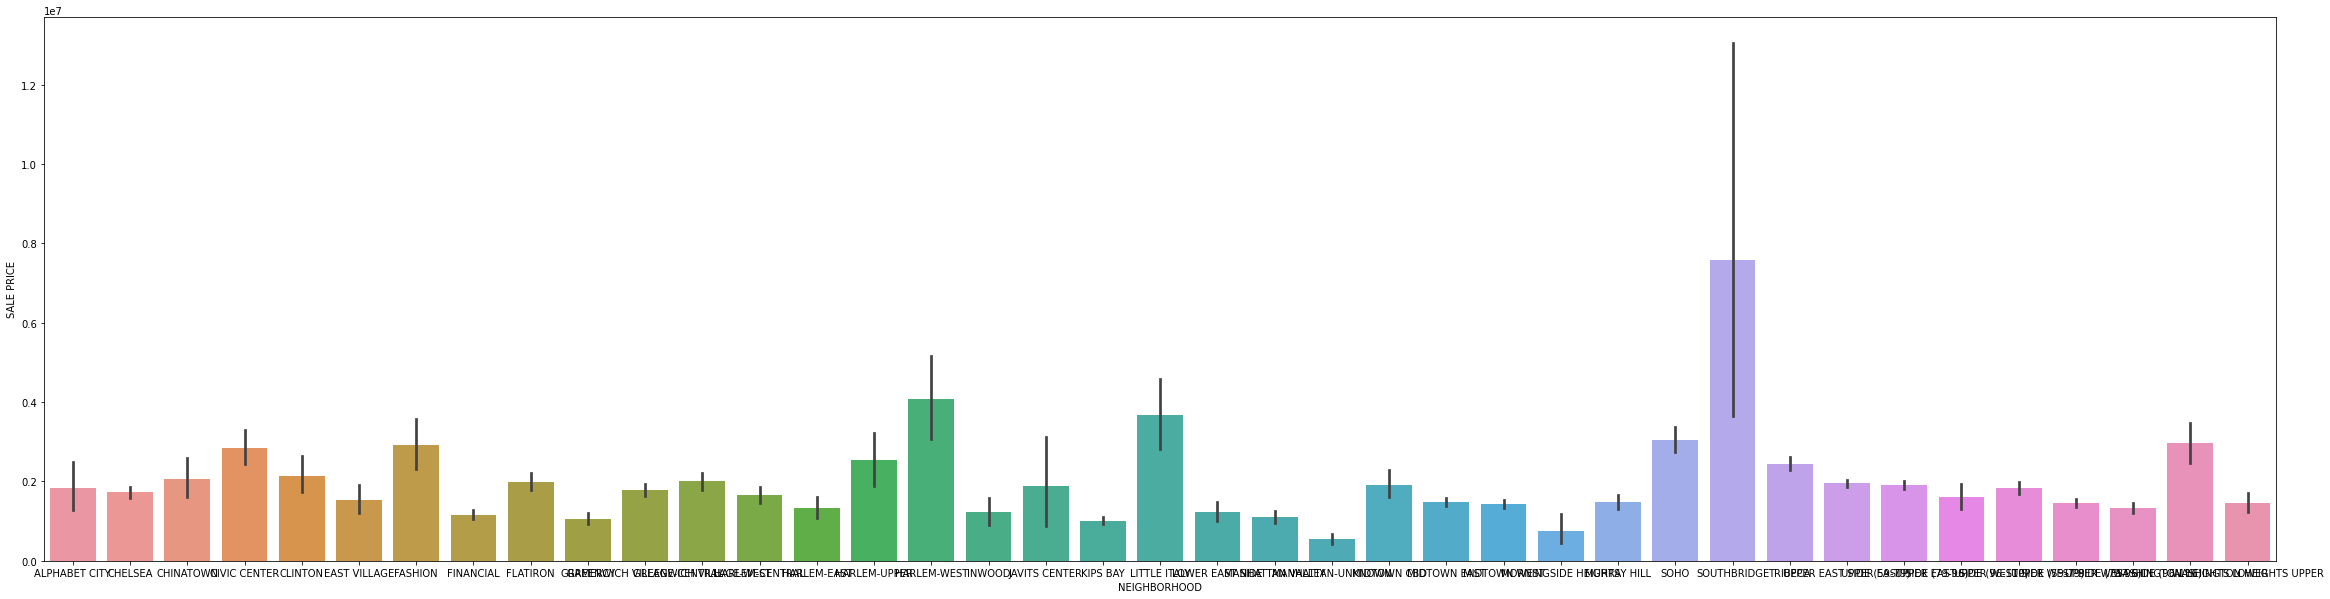

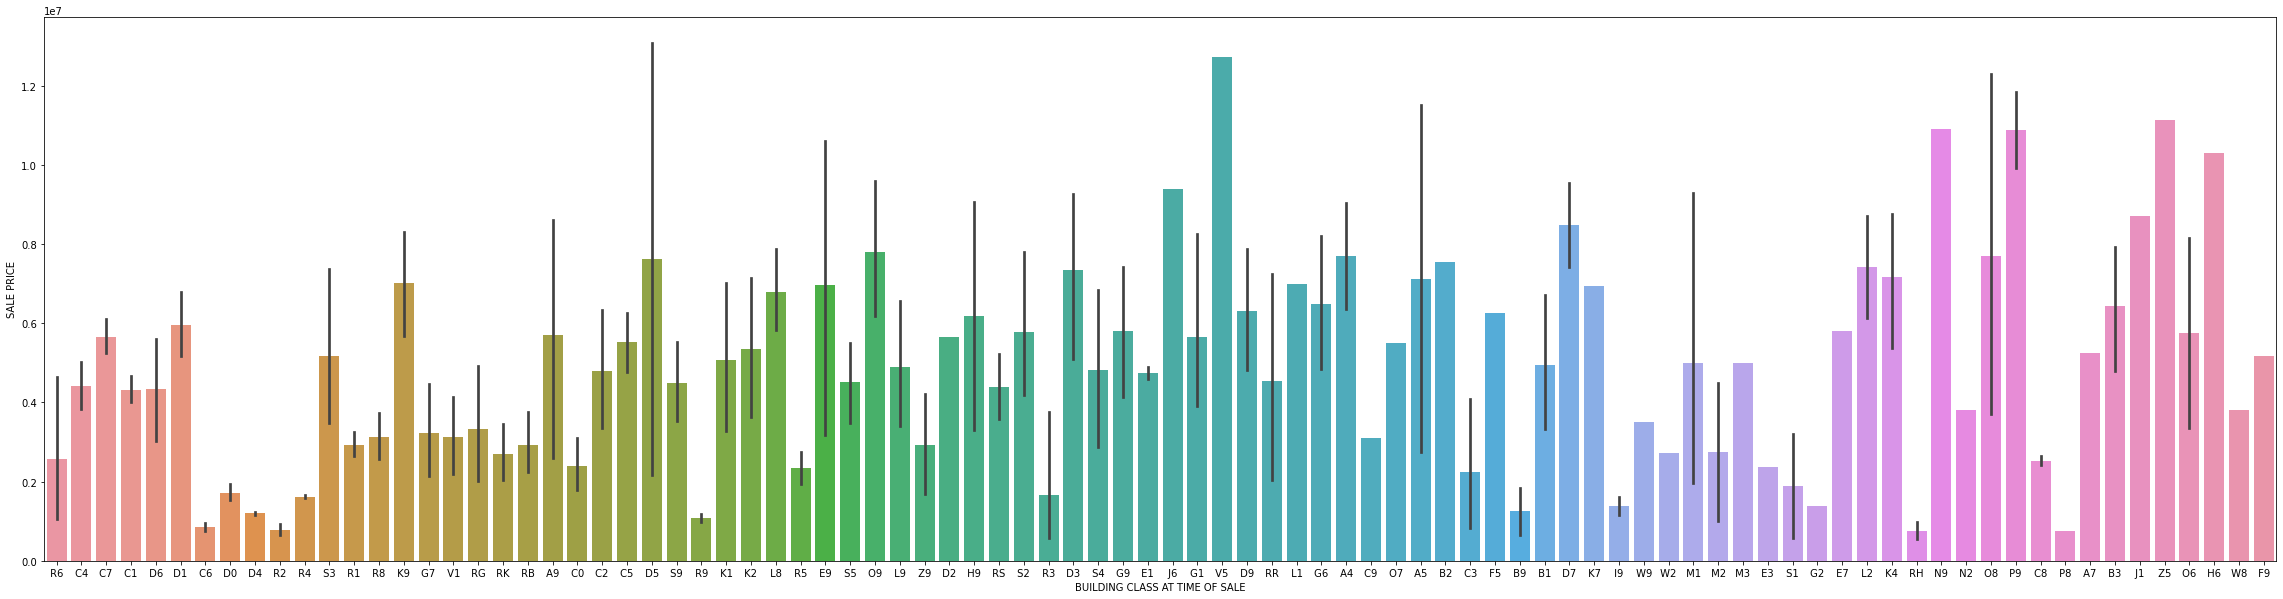

In [ ]:
bar_plot(df, 'NEIGHBORHOOD')
# there does seem to be a correlation between class of building and price (i.e D1 seems to sell for a lot) but not enough information in glossary about codes (like D1) to infer anything 
bar_plot(df, 'BUILDING CLASS AT TIME OF SALE')

<Axes: xlabel='SALE DATE', ylabel='SALE PRICE'>

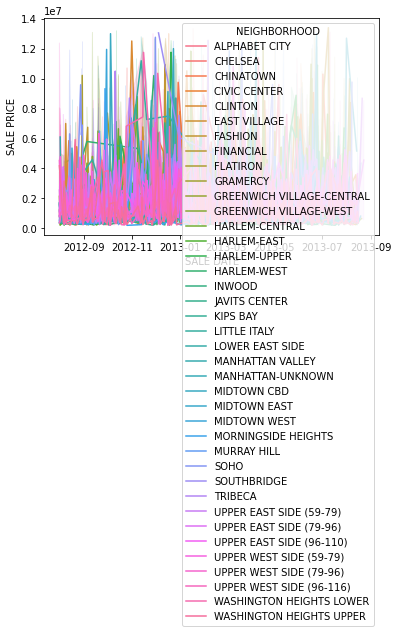

In [ ]:
sns.lineplot(data=df, x='SALE DATE', y='SALE PRICE', hue='NEIGHBORHOOD')

In [ ]:
# line plot above is very messy and unreadable so different line graphs will be created for each neighbourhood
neighbourhoods = df['NEIGHBORHOOD'].unique()

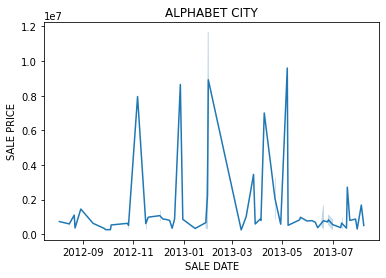

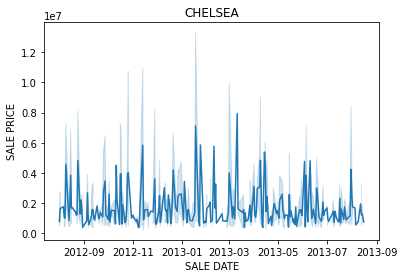

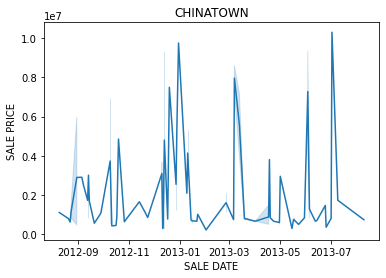

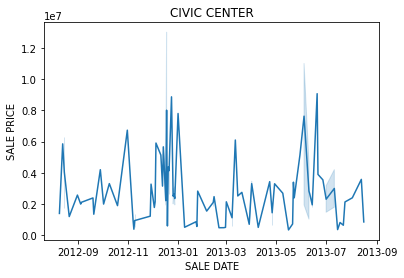

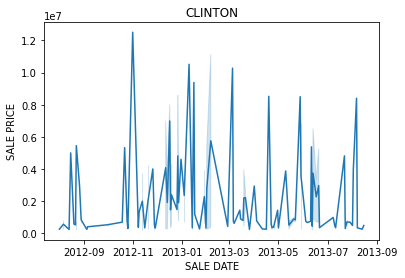

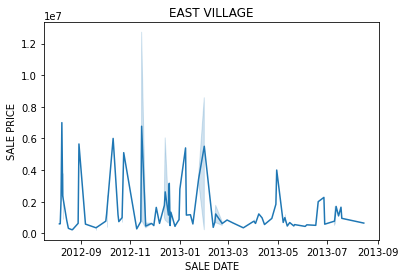

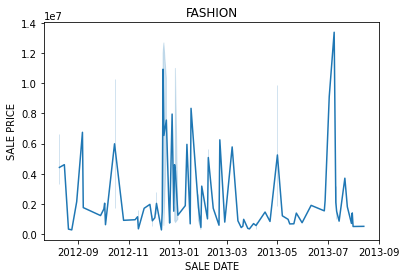

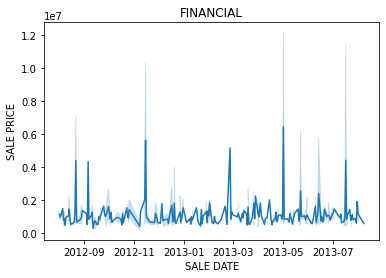

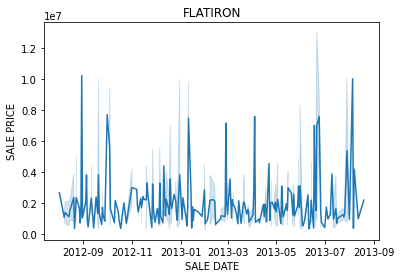

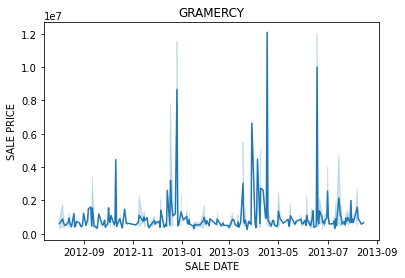

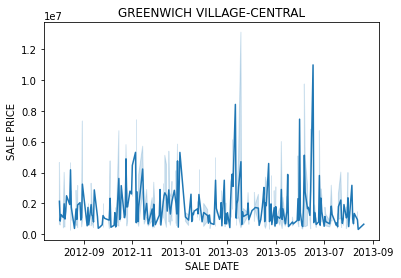

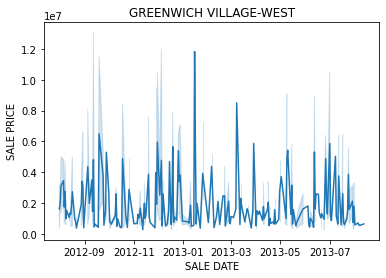

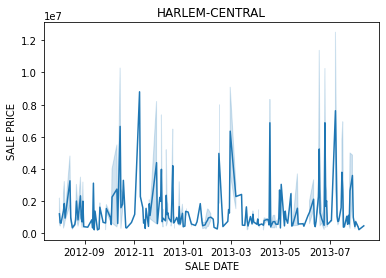

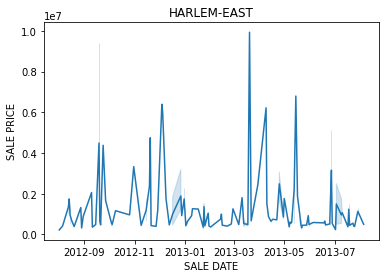

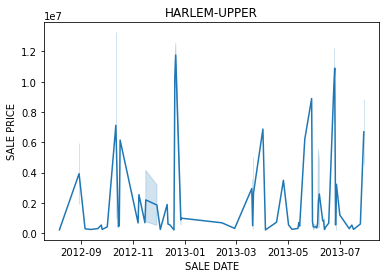

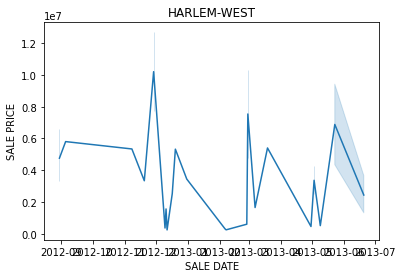

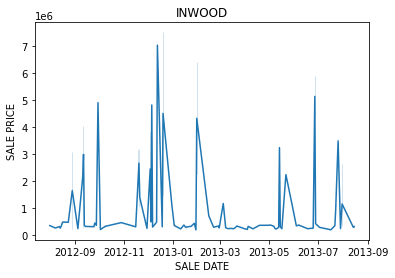

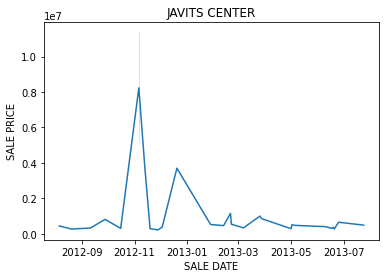

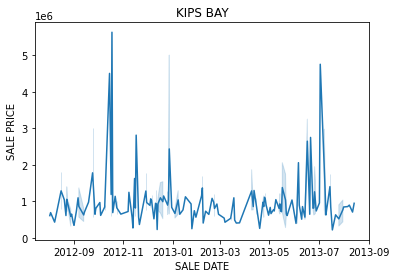

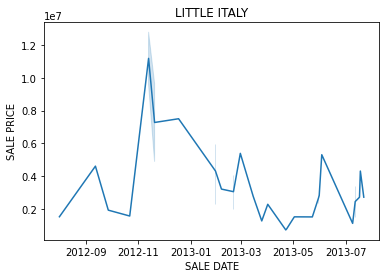

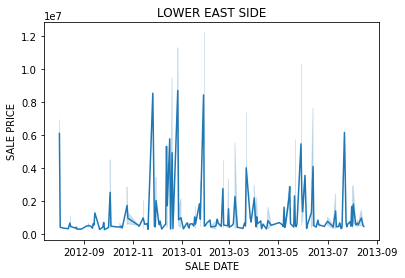

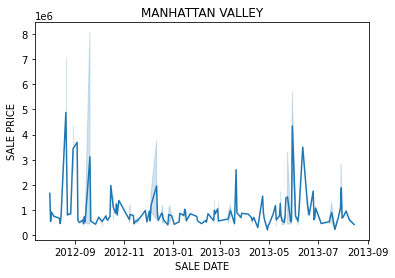

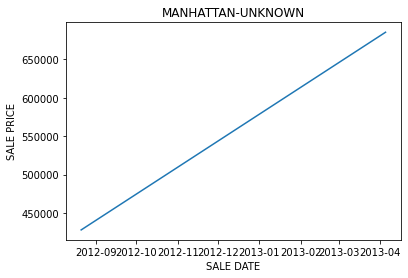

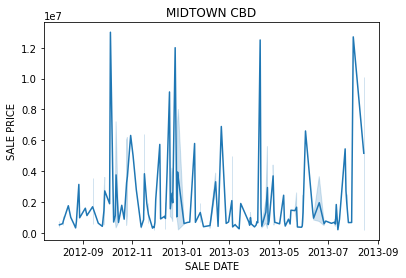

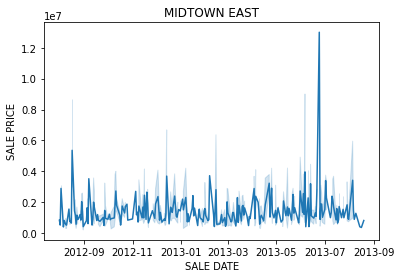

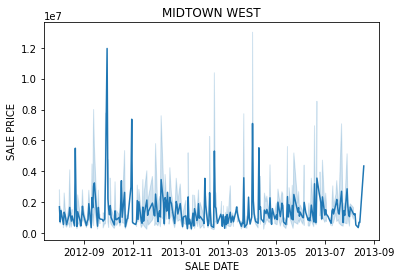

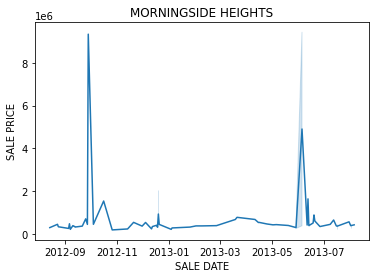

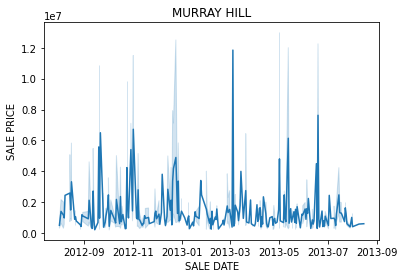

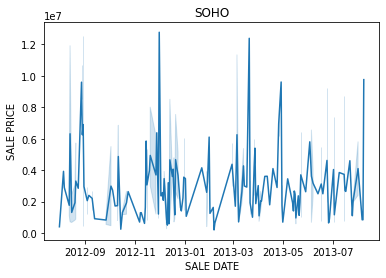

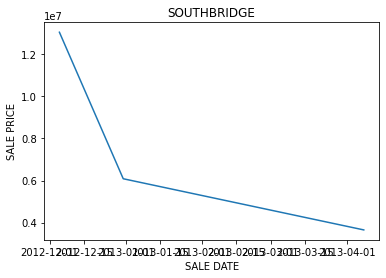

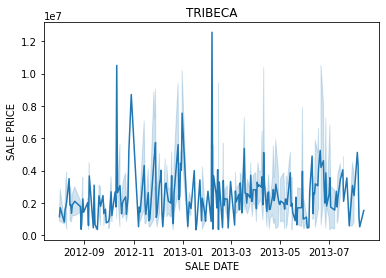

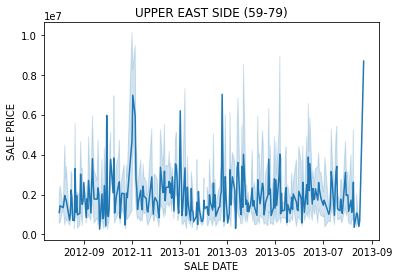

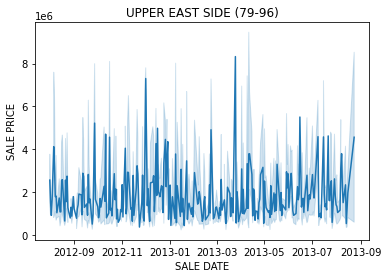

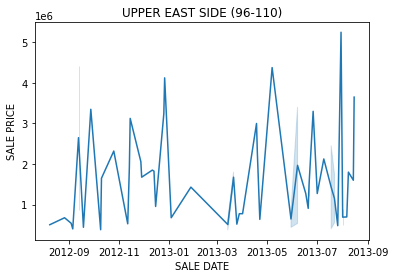

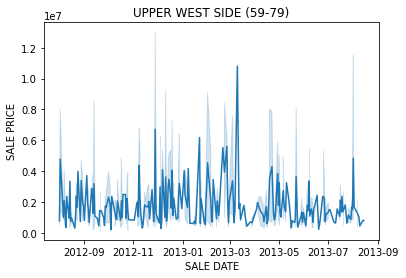

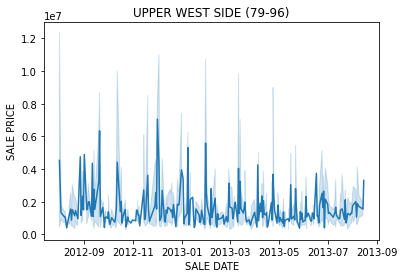

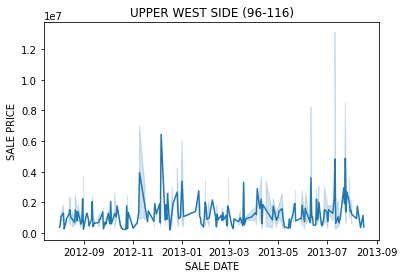

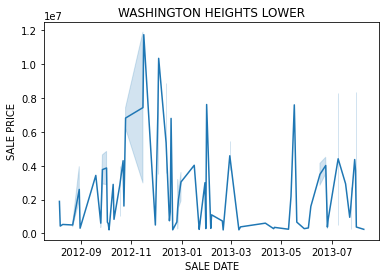

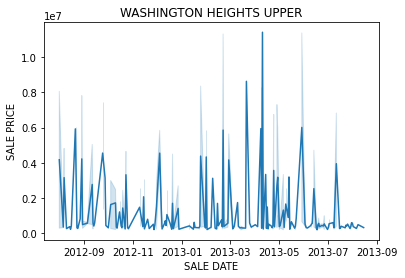

In [ ]:
def neighbourhood_price_date(df, neighbourhood):
    this_neighbourhood = df.query("NEIGHBORHOOD == " + "'" + neighbourhood + "'")
    sns.lineplot(data=this_neighbourhood, x='SALE DATE', y='SALE PRICE').set(title=neighbourhood)
    plt.show()


for i in neighbourhoods:
    neighbourhood_price_date(df, i)

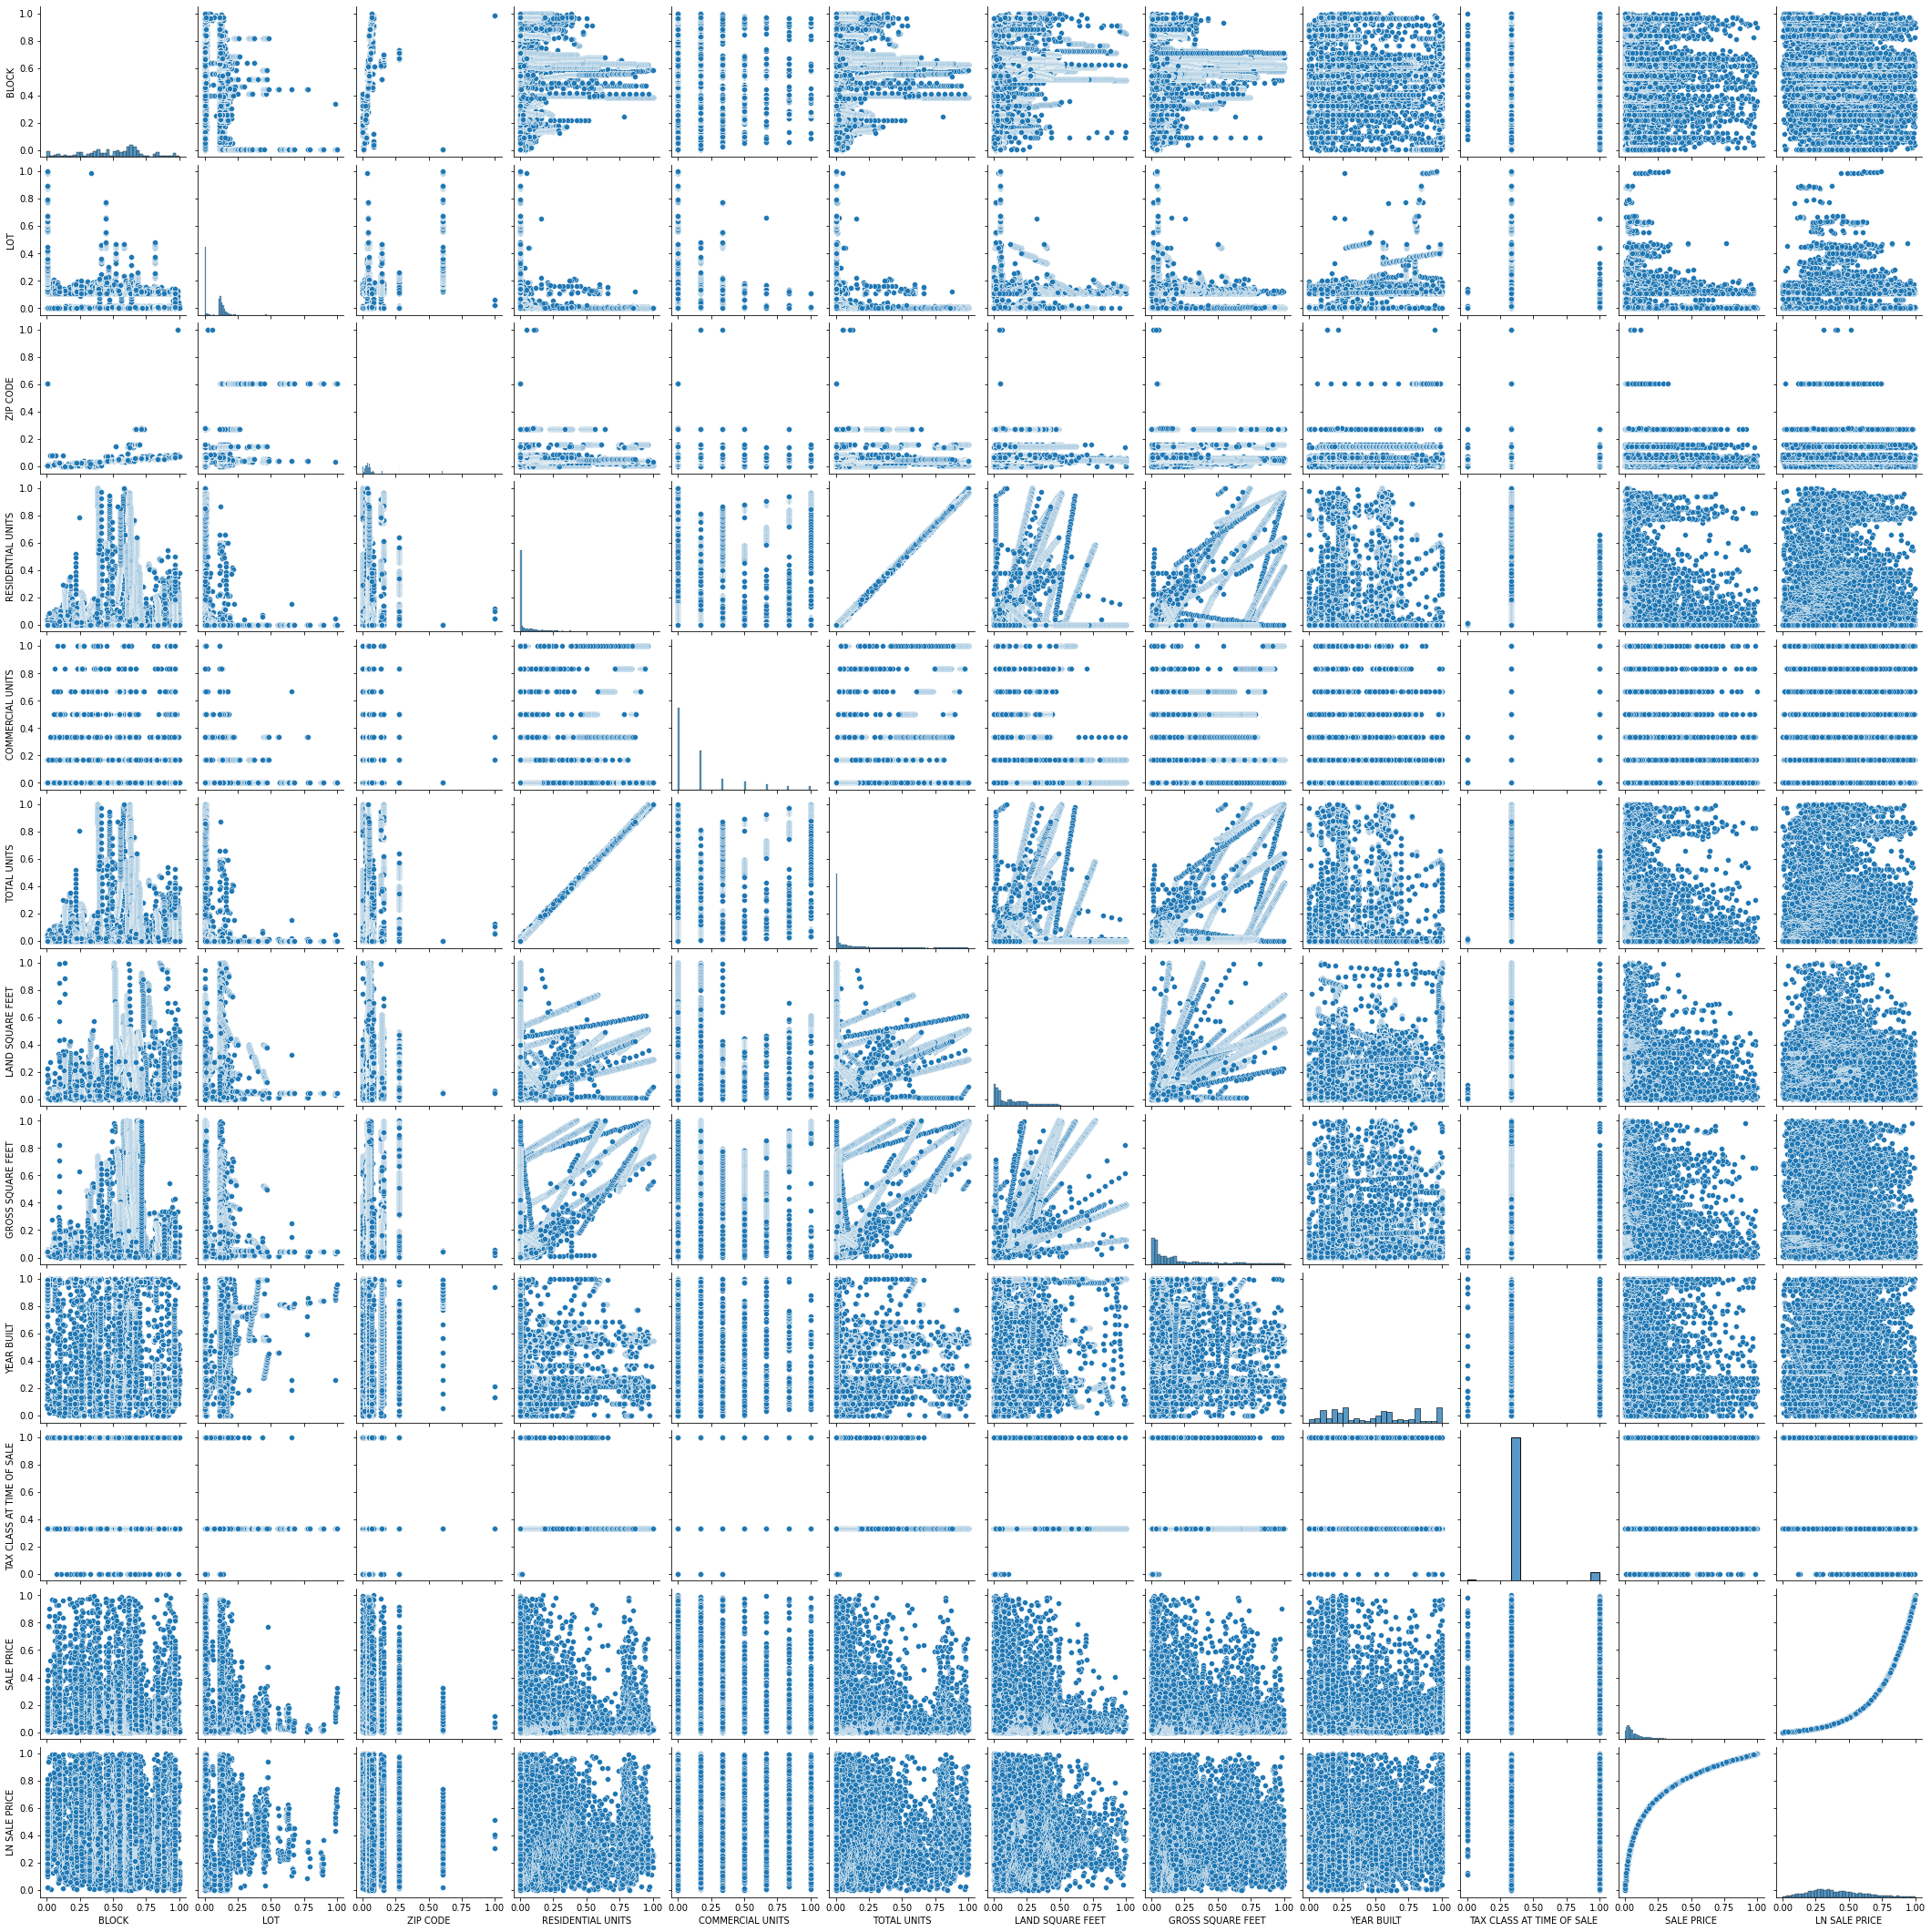

In [ ]:
sns.pairplot(df_norm)

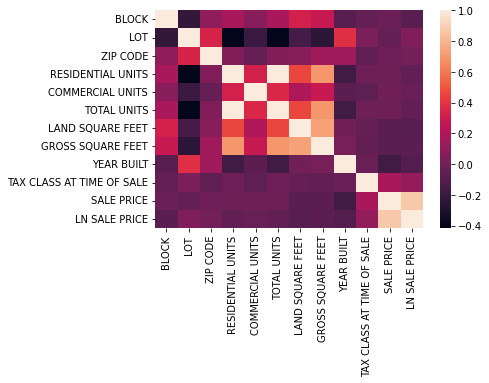

In [ ]:
def correlation_matrix(df):
    corr = df.corr()
    sns.heatmap(corr)

correlation_matrix(df)

### Model Building

In [40]:
# NOTE: max iter was changed to avoid 'The max_iter was reached' warning, also type of 'solver' was changed to avoid another warning
clf = LinearRegression()
feature_columns = ['TAX CLASS AT TIME OF SALE', 'RESIDENTIAL UNITS', 'ZIP CODE', 'TOTAL UNITS', 'LAND SQUARE FEET', "YEAR BUILT", "GROSS SQUARE FEET", "COMMERCIAL UNITS", "LOT", "BLOCK"]

X = df[feature_columns]
Y = df['SALE PRICE']

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

clf.fit(X_train, Y_train)

LinearRegression()

In [42]:
y_pred = clf.predict(X_test)

_preds_df = pd.DataFrame(dict(observed=Y_test, predicted=y_pred))
_preds_df.head()

observed     predicted
2913     836000  1.913167e+06
6219     799000  1.097780e+06
6041     750000  1.106645e+06
25306   1050000  2.063728e+06
2921     940000  1.914479e+06

In [43]:
from sklearn.metrics import mean_squared_error

print('Score: {}'.format(clf.score(X_test, Y_test)))
print('MSE: {}'.format(mean_squared_error(Y_test, y_pred)))

Score: 0.05747248958845752
MSE: 3829162816872.3706


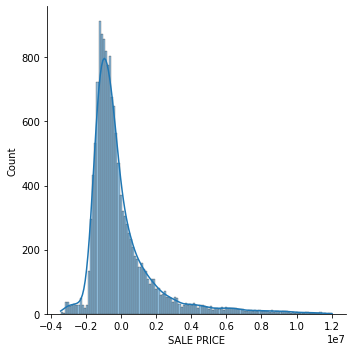

In [44]:
def model_hist(model, X, Y):
    pred_Y= model.predict(X)
    res = Y - pred_Y
    sns.displot(res, kde=True)
    plt.show()

model_hist(clf, X, Y)

In [45]:
def cross_val_mean(model, X, Y):
    return np.mean(cross_val_score(model, X, Y, cv=3, scoring='r2'))

score = cross_val_mean(clf, X_train, Y_train)
# NOTE: from my research, warning error above cross val score is just from not having a lot of data
print(score)

0.05500164546180064
